In [1]:
# cleaning data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import io
import re
from textblob import TextBlob
import seaborn as sns
import matplotlib.dates as mdates

# create the datasets with the tweets and their attributes
Trump_dataset = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
Biden_dataset = pd.read_csv('hashtag_joebiden.csv',lineterminator='\n')

# add a column of the candidate to differentiate them after merging the 2 datasets
Trump_dataset.loc[:,"candidate"] = 'Trump'
Biden_dataset.loc[:,"candidate"] = 'Biden'

ds_initial = pd.concat([Trump_dataset,Biden_dataset])
ds_initial.sort_values(by='likes')

created_at      tweet_id  \
0       2020-10-15 00:00:01  1.316529e+18   
19582   2020-10-16 02:30:50  1.316930e+18   
19581   2020-10-16 02:30:44  1.316930e+18   
19579   2020-10-16 02:30:40  1.316930e+18   
19578   2020-10-16 02:30:38  1.316930e+18   
...                     ...           ...   
536374  2020-11-06 16:31:06  1.324751e+18   
278831  2020-11-01 18:08:59  1.322964e+18   
298112  2020-11-02 15:25:15  1.323285e+18   
10623   2020-10-15 17:09:02  1.316788e+18   
20432   2020-10-16 03:17:29  1.316941e+18   

                                                    tweet     likes  \
0       #Elecciones2020 | En #Florida: #JoeBiden dice ...       0.0   
19582   Gregory #Aftandilian:\nShould former Vice Pres...       0.0   
19581   https://t.co/YrgntcfTVv\n\nAmazing #Biden vide...       0.0   
19579   So about those streaming numbers seemed steady...       0.0   
19578   Why is half his ass in a chair ?\n#StandUp #vo...       0.0   
...                                                   ...       ...   
536374  America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...   74528.0   
278831  That’s a pic of me in Pennsylvania when I live...   80670.0   
298112  Good morning PENNSYLVANIA! I’m so excited to s...  126772.0   
10623   The cowards at Twitter locked me out for expos...  143454.0   
20432   Tonight a woman in the audience of Trump's tow...  165702.0   

        retweet_count               source       user_id  \
0                 0.0            TweetDeck  3.606665e+08   
19582             1.0     Twitter for iPad  1.468291e+09   
19581             0.0      Twitter Web App  2.302227e+09   
19579             0.0   Twitter for iPhone  3.496644e+07   
19578             0.0  Twitter for Android  7.781238e+17   
...               ...                  ...           ...   
536374        20615.0   Twitter for iPhone  3.836269e+07   
278831         7553.0   Twitter for iPhone  1.423052e+07   
298112        14024.0   Twitter for iPhone  1.423052e+07   
10623         63473.0   Twitter for iPhone  7.852330e+07   
20432         17652.0      Twitter Web App  1.398238e+08   

                                                user_name user_screen_name  \
0                                      El Sol Latino News  elsollatinonews   
19582                                      Khalil Jahshan   KhalilEJahshan   
19581                                     Usecommon Sentz   UsecommonSentz   
19579                                               Andre       Andrel1331   
19578   NeoPolitan. #COVID #survival:#Mask/Glove/Glasses,         QwanZone   
...                                                   ...              ...   
536374                                 John Handem Piette      JohnHPiette   
278831                                          Lady Gaga         ladygaga   
298112                                          Lady Gaga         ladygaga   
10623                                         James Woods   RealJamesWoods   
20432                                         bettemidler      BetteMidler   

                                         user_description  ...  \
0       🌐 Noticias de interés para latinos de la costa...  ...   
19582   PERSONAL ACCOUNT - I have certain rules I live...  ...   
19581   Let us all Get out and Vote for Donald Trump. ...  ...   
19579   God, my man, my family, food Is all I need. Co...  ...   
19578   proactive\nPoliSci/DocFilm/Parents/Health/Ed/T...  ...   
...                                                   ...  ...   
536374  Director, Editor, Actor living the dream in Lo...  ...   
278831  “Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...  ...   
298112  “Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...  ...   
10623   This is the ONLY verified Twitter account for ...  ...   
20432   Kindness is the language which the deaf can he...  ...   

                        user_location        lat        long  \
0        Philadelphia, PA / Miami, FL  25.774270  -80.193660   
19582                  Washington, DC  38.89

In [2]:
# create a copy to preserve the original dataframe to avoid reloading it
ds = ds_initial.copy()

# add a date variable to more easily visualize it
ds['date_created'] = pd.to_datetime(ds_initial['created_at']).dt.date

# merge same data point from two different options
ds['country'].replace({'United States of America':'United States'}, inplace=True)
ds = ds[ds.country == 'United States']
# remove columns that we wont be using
ds = ds.drop(columns = ['created_at', 'tweet_id','collected_at','user_description','collected_at', 'source', 'user_id', 'user_name', 'user_screen_name', 'user_join_date', 'user_location',  'lat', 'long', 'city', 'country', 'continent', 'state'])

# if a tweet is tagged with both candidates then drop it as it wont be used
ds = ds.drop_duplicates(subset=ds.columns.difference(['candidate']), keep=False)

ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330659 entries, 2 to 776870
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tweet                 330659 non-null  object 
 1   likes                 330659 non-null  float64
 2   retweet_count         330659 non-null  float64
 3   user_followers_count  330659 non-null  float64
 4   state_code            279625 non-null  object 
 5   candidate             330659 non-null  object 
 6   date_created          330659 non-null  object 
dtypes: float64(3), object(4)
memory usage: 20.2+ MB


In [3]:
#Removes all words containing symbols, separate symbols and extra spaces.
ds["tweet"] = [re.sub("[^a-zA-Z ]", '' ,re.sub("(\w*[^a-zA-Z \n\t\r]+\w+)+", '', re.sub(" {2,}", '', i))) for i in ds["tweet"]]

#Uses textblob to find sentiment of the tweets
ds['sentiment'] = [TextBlob(i).sentiment.polarity for i in ds["tweet"]]

In [4]:
#Finds all unique states and removes ones that don't participate in the election

a = ds["state_code"].unique().tolist()
a = [i for i in a if str(i) not in ['nan', 'GU', 'MP', 'PR']]

a.sort()
#GU guam, MP northern mariana islands, PR puerto rico
#DC distrtict of columbia

In [5]:
#Creates dictionaries for both trump and biden containing all the states as keys and 0 as values
dict_trump = {i : [0, 0] for i in a}
dict_biden = {i : [0, 0] for i in a}


#Looks through the dataframe and adds or subtracts 1 to the value of the state in the dictionaries
for index, row in ds.iterrows():
    if row["state_code"] in dict_trump:
        if row["candidate"] == "Trump":
            if row["sentiment"] > 0:
                dict_trump[row["state_code"]][0] += 1
            else:
                dict_trump[row["state_code"]][1] += 1
        if row["candidate"] == "Biden":
            if row["sentiment"] > 0:
                dict_biden[row["state_code"]][0] += 1
            else:
                dict_biden[row["state_code"]][1] += 1

In [6]:
#Compares the two dictionaries and creates a new dictionary with state codes as the key and predicted winner as the value

dict_results = {i : '' for i in a}

for i in (dict_trump.keys()):
    if ((dict_trump[i][0]/dict_trump[i][1]) > (dict_biden[i][0]/dict_biden[i][1])):
        dict_results[i] = 'Trump'
    elif ((dict_biden[i][0]/dict_biden[i][1]) > (dict_trump[i][0]/dict_trump[i][1])):
        dict_results[i] = 'Biden'
    else:
        dict_results[i] = 'Tie'
        
print(dict_results)

{'AK': 'Trump', 'AL': 'Trump', 'AR': 'Biden', 'AZ': 'Trump', 'CA': 'Biden', 'CO': 'Biden', 'CT': 'Biden', 'DC': 'Biden', 'DE': 'Biden', 'FL': 'Trump', 'GA': 'Biden', 'HI': 'Trump', 'IA': 'Biden', 'ID': 'Trump', 'IL': 'Biden', 'IN': 'Biden', 'KS': 'Trump', 'KY': 'Trump', 'LA': 'Trump', 'MA': 'Trump', 'MD': 'Biden', 'ME': 'Trump', 'MI': 'Trump', 'MN': 'Biden', 'MO': 'Biden', 'MS': 'Trump', 'MT': 'Biden', 'NC': 'Biden', 'ND': 'Trump', 'NE': 'Trump', 'NH': 'Biden', 'NJ': 'Biden', 'NM': 'Biden', 'NV': 'Biden', 'NY': 'Biden', 'OH': 'Trump', 'OK': 'Trump', 'OR': 'Biden', 'PA': 'Trump', 'RI': 'Trump', 'SC': 'Biden', 'SD': 'Biden', 'TN': 'Biden', 'TX': 'Biden', 'UT': 'Trump', 'VA': 'Biden', 'VT': 'Trump', 'WA': 'Trump', 'WI': 'Biden', 'WV': 'Trump', 'WY': 'Trump'}


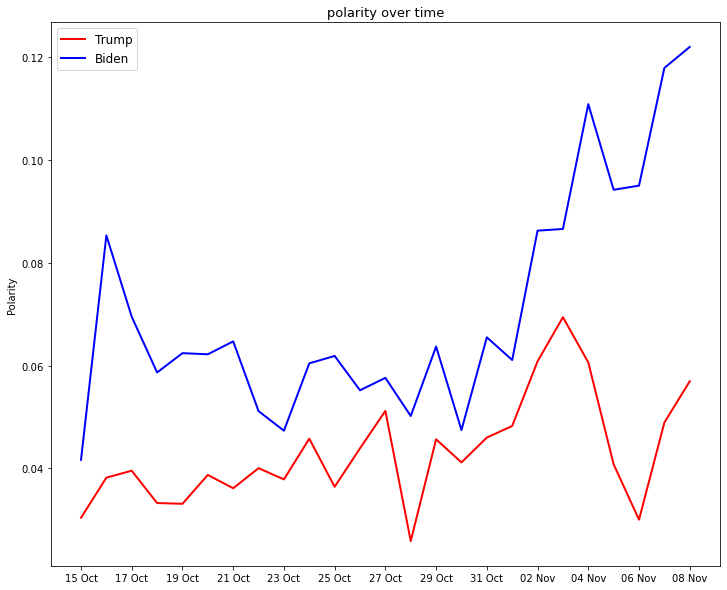

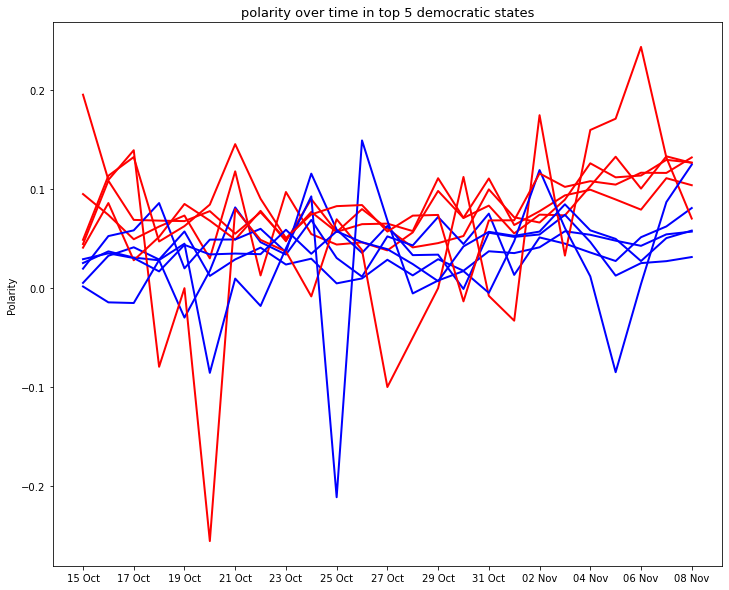

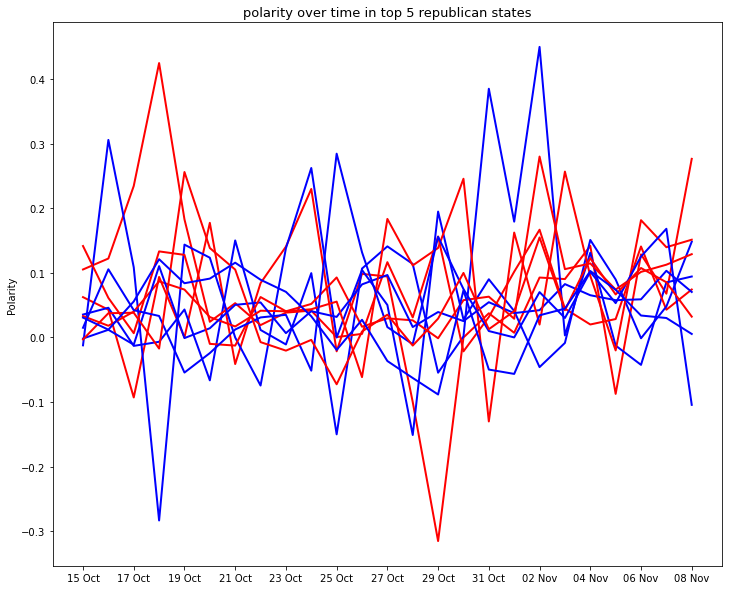

In [7]:
#visualising

# Graphs show that overall, the average polarity of #biden tweets is higher, but suprisingly,
# the polarity if higher for #trump in the top 5 states that biden won by most.
# The opposite is not true as top 5 republican won states have about equal polarity. 

# method for graphing data with set paramaters
def plot(data1, data2, sentiment, ax, title):
    sns.lineplot(data = data1.groupby('date_created')[sentiment].mean(), 
                 label = 'Trump', color = 'red', linewidth = 2, ax = ax)
    sns.lineplot(data = data2.groupby('date_created')[sentiment].mean(), 
                 label = 'Biden', color = 'blue', linewidth = 2, ax = ax)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.set_title(title, size = 13)
    ax.legend(prop={'size': 12})
    ax.set_ylabel('Polarity')
    
fig, ax1 = plt.subplots(figsize=(12, 10))
#plot overall sentiment polarity
plot(ds.loc[ds['candidate'] == "Trump"], ds.loc[ds['candidate'] == "Biden"], 'sentiment', ax1, 'polarity over time')

#plot top 5 democrat states on 1 graph
states=["CA","MA","TX","VT","NY"]
fig, ax1 = plt.subplots(figsize=(12, 10))

for state in states:
    plot(ds.loc[(ds['state_code'] == state) & (ds['candidate'] == "Biden")], ds.loc[(ds['state_code'] == state) & (ds['candidate'] == "Trump")], 'sentiment', ax1, "polarity over time in top 5 democratic states")
    ax1.legend().set_visible(False)
    
#plot top 5 republican states on 1 graph
states=["WY","WV","OH","ND","ID"]
fig, ax1 = plt.subplots(figsize=(12, 10))

for state in states:
    plot(ds.loc[(ds['state_code'] == state) & (ds['candidate'] == "Biden")], ds.loc[(ds['state_code'] == state) & (ds['candidate'] == "Trump")], 'sentiment', ax1, "polarity over time in top 5 republican states")
    ax1.legend().set_visible(False)

Text(0.5, 0.98, 'Sentiment polarity by state')

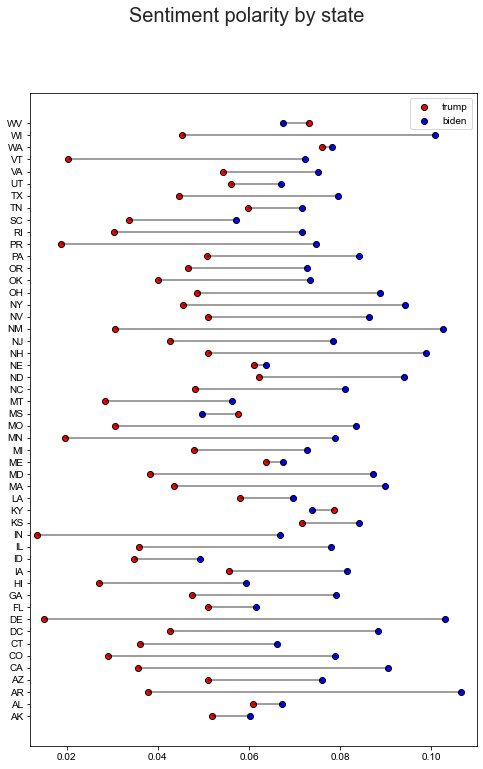

In [8]:


# graph showing the sentiment breakdown by state, also shows difference in polarity nicely
# took out 4 states because they had less than 400 tweets each
# Intresting points that positive, mostly democrat wins and republican wins are all close
states_polarised_trump = ds.loc[ds['candidate'] == "Trump"].groupby('state_code')['sentiment'].mean().drop(labels=["WY","SD","GU"])
states_polarised_biden = ds.loc[ds['candidate'] == "Biden"].groupby('state_code')['sentiment'].mean().drop(labels=["MP","WY","SD","GU"])

fig, ax = plt.subplots(1, 1, figsize=(8, 12)) 

ax.hlines(y = states_polarised_trump.index, xmin = states_polarised_trump, xmax = states_polarised_biden, color = "black", alpha = 0.5)
ax.scatter(states_polarised_trump, states_polarised_trump.index, color = "red", alpha = 1, edgecolors = 'black', label = 'trump')
ax.scatter(states_polarised_biden, states_polarised_biden.index, color = "blue", alpha = 1, edgecolors = 'black', label = 'biden')
ax.legend()
ax.set_xlim(0.012, 0.11)

sns.set_style("whitegrid")
fig.suptitle('Sentiment polarity by state', size = 20)



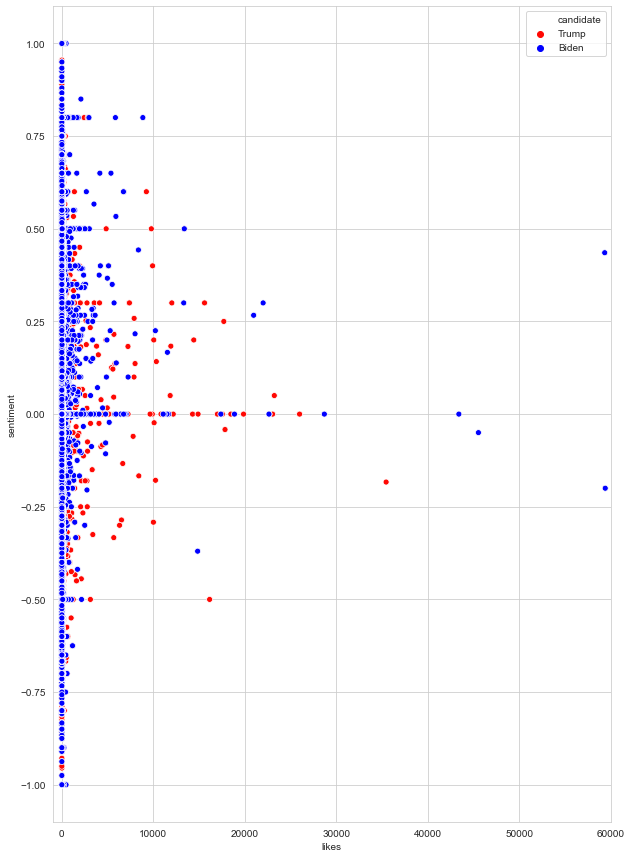

In [9]:
# graph of polarity against likes. Likes could be something else like follwers.
# interesting that most likes biden but also polarity spread quite evenly between biden and trump
colors = ["#ff0803", "#0000ff"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(10,15))
ax.set_xlim(-1000, 60000)
sns.scatterplot(ax=ax,data=ds, y="sentiment", x="likes", hue="candidate")
